## Exploratory Data Analysis

In this section we will run data exploration to provide some guidance on what data transformations are necessary to produce accurate results.

In [82]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [83]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [17]:
sc.stop()

In [18]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "vishal_finalproject"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .config("spark.executor.memory", "20g") \
        .config("spark.driver.memory", "20g") \
        .getOrCreate()
sc = spark.sparkContext

#### Step 1: We will read the data as a Spark Dataframe.

In [19]:
#pyspark dependencies
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.sql import SQLContext, functions
from pyspark.sql.types import *

In [20]:
# 13 features taking integer values and 26 taking categorical values (we can't assume ordinal) - making total of 39 features + 1 outcome
outcomeField = [StructField("label", IntegerType(), True)]
quantFields = [StructField("intFeature"+str(i+1), IntegerType(), True) for i in np.arange(13)]
qualFields = [StructField("catFeature"+str(i+1), StringType(), True) for i in np.arange(26)]
schema = StructType(outcomeField + quantFields + qualFields)

In [21]:
#read in the txt file
#----per readme: when a value is missing, the field is just empty---#
file = "train.txt"
df_train = spark.read.schema(schema) \
    .option("delimiter", "\t") \
    .option("ignoreLeadingWhiteSpace",True) \
    .option("ignoreTrailingWhiteSpace",True) \
    .csv(file,nullValue = "")

In [22]:
df_train.count()

45840617

We will run our EDA on 5% sample. Doing a random sample ensures that we get a good representation of the data to draw some intution on.

In [23]:
df_eda = df_train.sample(False, 0.05)

In [24]:
df_eda.count()

2290742

In [25]:
df_eda.printSchema()

root
 |-- label: integer (nullable = true)
 |-- intFeature1: integer (nullable = true)
 |-- intFeature2: integer (nullable = true)
 |-- intFeature3: integer (nullable = true)
 |-- intFeature4: integer (nullable = true)
 |-- intFeature5: integer (nullable = true)
 |-- intFeature6: integer (nullable = true)
 |-- intFeature7: integer (nullable = true)
 |-- intFeature8: integer (nullable = true)
 |-- intFeature9: integer (nullable = true)
 |-- intFeature10: integer (nullable = true)
 |-- intFeature11: integer (nullable = true)
 |-- intFeature12: integer (nullable = true)
 |-- intFeature13: integer (nullable = true)
 |-- catFeature1: string (nullable = true)
 |-- catFeature2: string (nullable = true)
 |-- catFeature3: string (nullable = true)
 |-- catFeature4: string (nullable = true)
 |-- catFeature5: string (nullable = true)
 |-- catFeature6: string (nullable = true)
 |-- catFeature7: string (nullable = true)
 |-- catFeature8: string (nullable = true)
 |-- catFeature9: string (nullable = 

#### Step 2A: Explore the outcome variable

In [27]:
df_eda.describe("label").show()

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|            2290742|
|   mean|   0.25640949526398|
| stddev|0.43665060315401083|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



Observations:
1. No missing labels
2. About 25% of the data has label of 1, rest is 0

#### Step2B: Explore the integer variables

In [32]:
intField = ["intFeature"+str(i+1) for i in np.arange(13)]
df_eda.describe(intField[0:5]).show()

+-------+------------------+------------------+------------------+-----------------+-----------------+
|summary|       intFeature1|       intFeature2|       intFeature3|      intFeature4|      intFeature5|
+-------+------------------+------------------+------------------+-----------------+-----------------+
|  count|           1251973|           2290742|           1798844|          1793714|          2231606|
|   mean| 3.500741629412136|105.77646675182102|27.241573477188684|7.325144922769182|18561.75362496785|
| stddev|10.763826409685095| 388.8206487522046|417.36443434414315| 8.78218312426576| 69366.5832509991|
|    min|                 0|                -2|                 0|                0|                0|
|    max|              5775|             22066|             65535|              877|          2693697|
+-------+------------------+------------------+------------------+-----------------+-----------------+



In [31]:
df_eda.describe(intField[5:-1]).show()

+-------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|summary|       intFeature6|      intFeature7|       intFeature8|       intFeature9|      intFeature10|     intFeature11|      intFeature12|
+-------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|  count|           1778838|          2191810|           2289628|           2191810|           1251973|          2191810|            538685|
|   mean|115.78978580399115|16.32112318129765|12.512350041142055|106.27886313138457| 0.616346358907101|2.732559847797026|0.9793497127263614|
| stddev|339.55633109634385|64.94632207402276|16.441711026891348|221.04241607716455|0.6823417352237863|5.197463941079758|  7.40620978735608|
|    min|                 0|                0|                 0|                 0|                 0|                0|                 0|
|    max|    

Observations:
1. Fields intFeature12 has a very large number of nulls (~80%). Recommendation - Remove it from the analysis
2. The spread in values is very large for almost all the features. We should draw a histogram to understand the distribution of the feature values.
3. Feature intFeature4 seems to be very concentrated around the mean. We should draw a histogram to better understand the distribution.
4. intFeature2 has a negative value. ToDo: print the number of negative values

In [34]:
df_eda_pandas = df_eda.select(intField).toPandas()

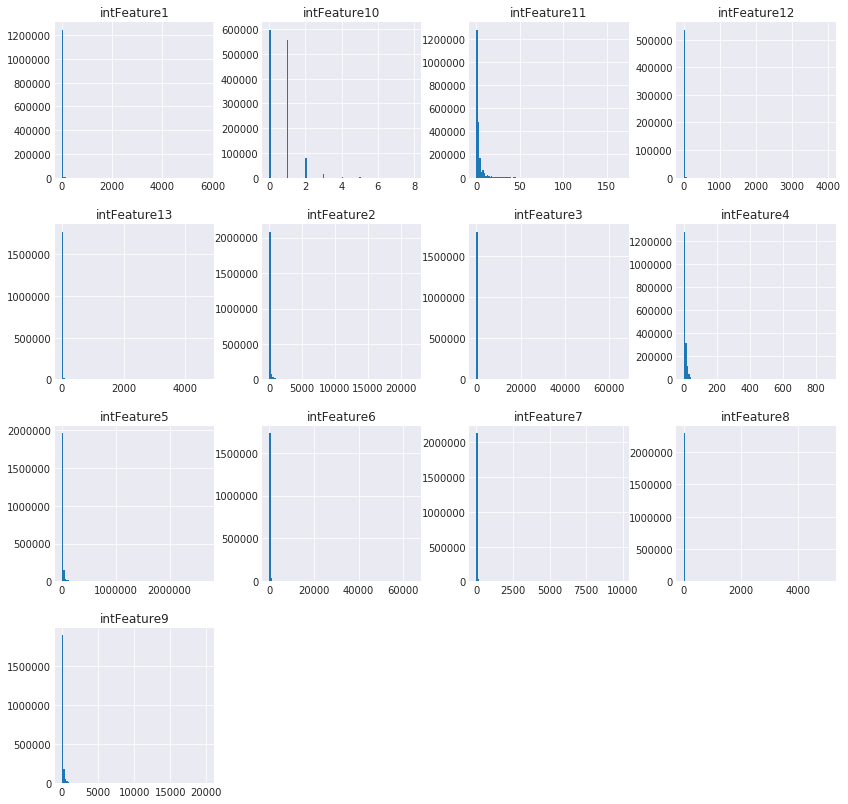

In [35]:
df_eda_pandas.hist(figsize=(14,14), bins=100)
plt.show()

Observations:
1. Most features are left skewed and we should look into taking log transformations
2. The featurs should be normalized so they all appear on the same scale

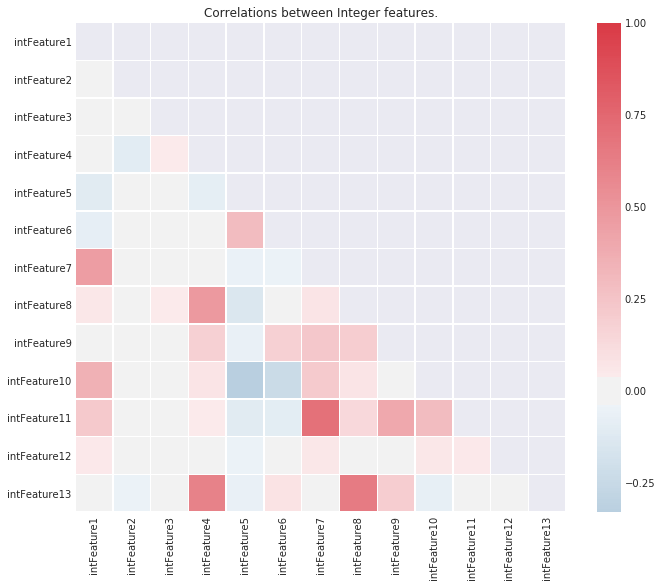

In [36]:
corr = df_eda_pandas.corr()

fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)

plt.title("Correlations between Integer features.")
plt.show()


Observations:
1. The following features show very strong correlation: intFeature4 - intFeature13, intFeature8 - intFeature13, intFeature11 - intFeature7. Recommendation to drop intFeature13 and 11

#### Step2C: Explore the categorical variables

In [47]:
#Let's check for unique counts
uniqueCounts = {}
for field in catField:
    uniqueCounts[field] = df_eda.select(field).distinct().count()
uniqueCounts

{'catFeature1': 1415,
 'catFeature2': 554,
 'catFeature3': 753683,
 'catFeature4': 257432,
 'catFeature5': 297,
 'catFeature6': 16,
 'catFeature7': 11727,
 'catFeature8': 615,
 'catFeature9': 3,
 'catFeature10': 42432,
 'catFeature11': 5110,
 'catFeature12': 662310,
 'catFeature13': 3170,
 'catFeature14': 26,
 'catFeature15': 10981,
 'catFeature16': 489887,
 'catFeature17': 10,
 'catFeature18': 4522,
 'catFeature19': 1975,
 'catFeature20': 4,
 'catFeature21': 589847,
 'catFeature22': 16,
 'catFeature23': 15,
 'catFeature24': 69022,
 'catFeature25': 80,
 'catFeature26': 47532}

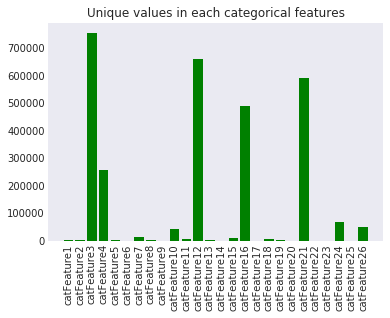

In [56]:
plt.bar(uniqueCounts.keys(), uniqueCounts.values(), color='g')
plt.title("Unique values in each categorical features")
plt.xticks(rotation=90)
plt.show()

Observation:
Some categorical variables (such as catFeature3) have a large number of unique values. They should be binned using some techniques. 
<br>(a) They can be binned based on frequency.
<br>(b) They can be binned based on average value of the outcome variable.

This will be required before we one-hot encode these categorical variables

In [85]:
#Let's check for null values
def descCatEDA(dataframe, column, totalCount=0, nanThreshold=0.5):
    """
    Function that prints an analysis of column from the given dataframe. Retuns None.
    Args:
        dataframe    - input dataframe
        column       - string with a dataframe column.
        totalCount   - optional. Number of rows in the dataframe (if defined avoid recalculation).
        nanThreshold - optional. Percentage allowed of NaN values in the column.
    Returns:
        Column       - name of the column if the column have more NaN if it represents more 
                       than nanThreshold ratio.
    Output:
        NaN Count    - number for NaN values in % of the row count of the dataframe.
        Most Freq    - number of values for the 5 most frequent values (discarding NaN).
        
    """
    if totalCount == 0:
        totalCount = dataframe.count()
    
    pandCol = dataframe.select(column).toPandas()[column]
    freqNumbers = dict(pandCol.value_counts(normalize=True).head(5))
    
    nanCount = dataframe.filter(dataframe[column].isNull()).count()
    
    validCount = totalCount - nanCount
    
    print('+'+13*'-'+'+'+22*'-'+'+')
    print('|Feature: {:^4}'.format(column)+'|{:>14}{:>6.2f}% |'.format('Null Count: ', nanCount/totalCount*100))
    print('+'+13*'-'+'+'+22*'-'+'+')
    print('| Unique Values: {:>19} |'.format(pandCol.nunique()))
    print('+'+13*'-'+'+'+22*'-'+'+')
    for item in freqNumbers:
        print('|{:>12} |{:>20.2f}% |'.format(item, freqNumbers[item]*100))
    print('+'+13*'-'+'+'+22*'-'+'+\n')
    
    if nanCount/totalCount*100 > nanTreshold*100:
        return column
    else:
        return None

In [86]:
badFeatures = []
totalCount = 2290742
nanTreshold = 0.5

for item in catField:
    badFeatures.append(descCatEDA(df_eda, item, totalCount, nanTreshold))

badFeatures = list(filter(None,badFeatures))
print('List of feature with more than {:4.2f}% NaN ratio: {}'.format(nanTreshold*100, badFeatures))

+-------------+----------------------+
|Feature: catFeature1|  Null Count:   0.00% |
+-------------+----------------------+
| Unique Values:                1415 |
+-------------+----------------------+
|    05db9164 |               50.05% |
|    68fd1e64 |               16.66% |
|    5a9ed9b0 |                8.36% |
|    8cf07265 |                4.97% |
|    be589b51 |                3.28% |
+-------------+----------------------+

+-------------+----------------------+
|Feature: catFeature2|  Null Count:   0.00% |
+-------------+----------------------+
| Unique Values:                 554 |
+-------------+----------------------+
|    38a947a1 |               11.43% |
|    207b2d81 |                4.33% |
|    38d50e09 |                3.83% |
|    1cfdf714 |                3.63% |
|    287130e0 |                3.58% |
+-------------+----------------------+

+-------------+----------------------+
|Feature: catFeature3|  Null Count:   3.40% |
+-------------+----------------------+
| 